### Variational inference using transport with PyTorch

Mathematical description: Consider the posterior distribution 
$$\pi^y(u) \propto \rho(u)\mathsf{I}(y|u)$$

Approximate $\pi^y(u) \approx T(\cdot;\theta)_\#\varrho(u)$ for a reference distribution $\varrho$ by minimizing the KL divergence:
\begin{align*}
\min_\theta D_{KL}(T(\cdot,\theta)_\#\varrho||\pi^y) &= \min_\theta D_{KL}(\varrho||T(\cdot,\theta)^\#\pi^y) \\
\end{align*}

Minimizing the reverse KL is equivalent to
\begin{align*}
\arg\min_\theta D_{KL}(\varrho||T(\cdot,\theta)^\#\pi^y) = \arg\min_\theta -\mathbb{E}_{z \sim \varrho}[\log \rho \circ T(z,\theta) + \log \mathsf{I}(y| T(z,\theta)) + \log\det\nabla_z T(z,\theta)]
\end{align*}

Given i.i.d. samples $z^{(1)}, \ldots, z^{(N)}$ from the reference distribution $\varrho$, we minimize
\begin{equation}
\widehat{T} = \arg\min_{\theta} \frac{1}{N} \sum_{i=1}^N -\log\rho \circ T(z^{(i)},\theta) - \log \mathsf{I}(y| T(z^{(i)},\theta)) - \log\det\nabla_z T(z^{(i)},\theta),
\end{equation}
After learning the map, we can sample the approximate posterior:
$$u^{(i)} = \widehat{T}(z^{(i)};\theta), \;\; z^{(i)} \sim \varrho$$
Or approximate the posterior density:
$$\pi^y(u) \approx T(\cdot;\theta)_\#\varrho(u) = \varrho(\widehat{T}^{-1}(u;\theta))|\det\nabla_u T^{-1}(u;\theta)|$$

In [2]:
import torch
from torch import nn
import numpy as np
from torch import distributions
import matplotlib.pyplot as plt

## Posterior for Biochemical Oxygen Demand Model

**Parameters**:
$$A \sim U(0.4,1.2), \text{ and  }  B \sim U(0.01,0.31)$$

Transform uniform variables to $\R^2$ using uniform CDF: $\Phi : \R \rightarrow [0,1]$
\begin{align*}
A &= 0.4 + 0.4\Phi(u_1)\\
B &= 0.01 + 0.15\Phi(u_2)
\end{align*}

**Prior**:
$$u \sim \mathcal{N}(0,I_2)$$

**Forward Model**: 
$$\mathfrak{B}(t;u) = A(1−\exp(−Bt))$$
$$G(u) = [\mathfrak{B}(1;u),\mathfrak{B}(2;u),\mathfrak{B}(3;u),\mathfrak{B}(4;u),\mathfrak{B}(5;u)]$$
$$y = G(u) + \eta, \qquad \eta \sim \mathcal{N}(0, \Gamma), \Gamma = 10^{-3} I_5$$

Our goal will be to sample $u \in \mathbb{R}^2$ conditioned on a data measurement $y \in \mathbb{R}^5$.

In [5]:
class posterior():
    def __init__(self, y=None):
        self.obs_time = torch.tensor([1,2,3,4,5])
        self.gamma_var = torch.tensor(1e-3)
        self.prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
        self.lik = distributions.MultivariateNormal(torch.zeros(5), torch.eye(5)*self.gamma_var)
        self.y = y #fixed data
        
    def forward_model(self, x):
        # compute model parameters A and B
        A = 0.4 + 0.4*(1 + torch.erf(x[:,0]/torch.sqrt(torch.tensor(2.))))
        B = 0.01 + 0.15*(1 + torch.erf(x[:,1]/torch.sqrt(torch.tensor(2.))))
        # evaluate exponential model
        return (A * (1 - torch.exp(-1*B*self.obs_time[:,None]))).T
        
    def sample_data(self, x):
        # evaluate model
        Gx = self.forward_model(x)
        # evaluate noise
        noise = self.lik.sample((x.shape[0],))
        return Gx + noise
    
    def log_likelihood(self, x):
        return self.lik.log_prob(self.y - self.forward_model(x))

    def log_prior(self, x):
        return self.prior.log_prob(x)
    
    def log_prob(self, x):
        return self.log_likelihood(x) + self.log_prior(x)

# test posterior evaluations
y = torch.tensor([0.1615, 0.1868, 0.3949, 0.3728, 0.4177])
pi = posterior(y=y)

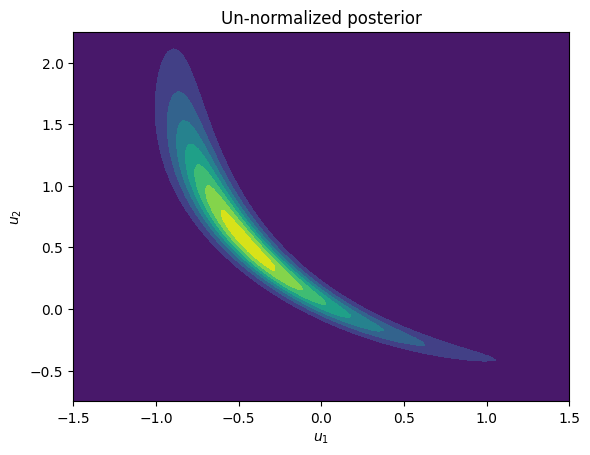

In [6]:
# define domain
domain_x1 = [-1.5,1.5]
domain_x2 = [-0.75,2.25]

# grid of the spatial domain (for plotting)
x1 = torch.linspace(domain_x1[0],domain_x1[1], 100)
x2 = torch.linspace(domain_x2[0],domain_x2[1], 100)
xg = torch.meshgrid(x1, x2)
xx = torch.cat((xg[0].reshape(-1, 1), xg[1].reshape(-1, 1)), 1)

plt.figure()
plt.contourf(xg[0],xg[1],torch.exp(pi.log_prob(xx).detach().reshape(len(x1), len(x2))))
plt.xlim(domain_x1)
plt.ylim(domain_x2)
plt.xlabel("$u_1$")
plt.ylabel("$u_2$")
plt.title('Un-normalized posterior')
plt.show()

## Define model

Here we will use normalizing flows (Real NVP layers) for the map $T(z,\theta)$
\begin{equation*}
    T(z;\theta) = L_K \circ L_{K-1} \circ \cdots \circ L_1(z),
\end{equation*}
where $L_j \colon \mathbb{R}^2 \rightarrow \mathbb{R}^2$ repeats the following two maps:
$$L_1(y) = \begin{bmatrix*} y_1 \\ a(y_1) + \exp(b(y_1))y_2 \end{bmatrix*}, \qquad L_2(y) = \begin{bmatrix*} a(y_2) + \exp(b(y_2))y_1 \\ y_2 \end{bmatrix*},$$
where $a,b$ are parameterized using neural networks. This is monotone and invertible by construction.

Each layer has an analytical inverse and log-determinant of the Jacobian:
$$L_1^{-1}(z) = \begin{bmatrix*} z_1 \\ (z_2 - a(y_1))/\exp(b(z_1)) \end{bmatrix*}, \qquad \log\det \nabla_y L_1(y) = b(y_1)$$

We implement these layers using masks that alternate between the two variables, i.e.,
\begin{equation*}
L_j\left(y\right) = m_{j} \odot y + (1-m_{j}) \odot \left(y \odot \exp\left(b( y \odot m_{j})\right) + a\left(y \odot m_{j}\right)\right),
\end{equation*}
where $m_{1} = [0,1], m_2 = [1,0], ...$ is used to mask some components of the inputs.

In [8]:
#RealNVP class

class RealNVP(nn.Module):
    def __init__(self, nets, nett, masks, pi, ref):
        super(RealNVP, self).__init__()
        self.pi  = pi
        self.ref = ref
        self.mask = nn.Parameter(masks, requires_grad=False)
        self.a = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.b = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def T(self, z):
        log_det_J, x = z.new_zeros(z.shape[0]), z
        x = z
        for i in range(len(self.a)):
            x_ = x*self.mask[i]
            b = self.b[i](x_)*(1 - self.mask[i])
            a = self.a[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(b) + a)
            log_det_J += b.sum(dim=1)
        return x, log_det_J

    def Tinv(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.a))):
            z_ = self.mask[i] * z
            b = self.b[i](z_) * (1-self.mask[i])
            a = self.a[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - a) * torch.exp(-b) + z_
            log_det_J -= b.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,z):
        x, logdet = self.T(z)
        return self.pi.log_prob(x) + logdet

    def approximate_log_prob(self,z):
        x, logdet = self.Tinv(z)
        return self.ref.log_prob(x) + logdet

    def sample(self, batchSize): 
        z = self.ref.sample((batchSize,))
        x, _ = self.T(z)
        return x

## Train model

  step     J_NF   


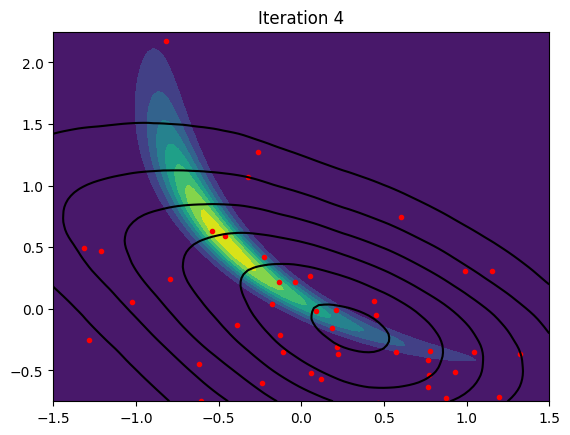

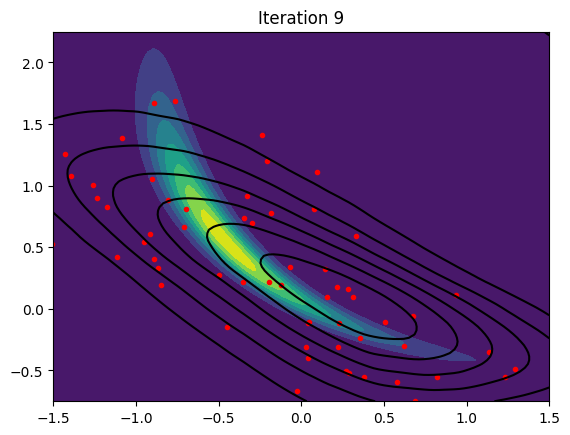

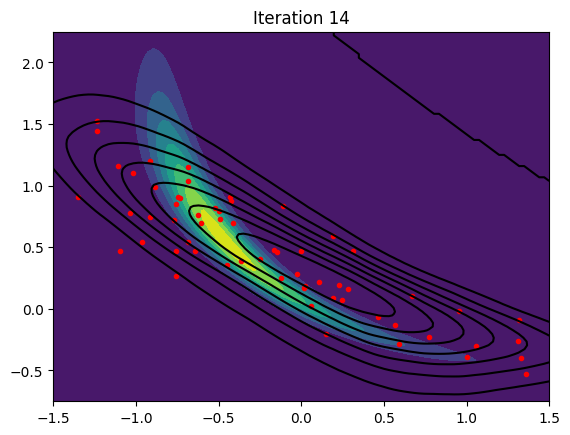

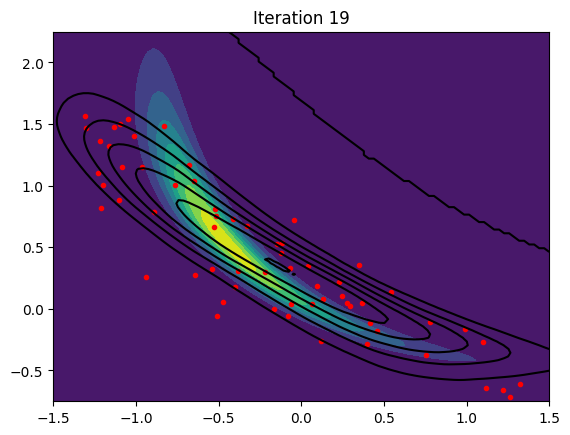

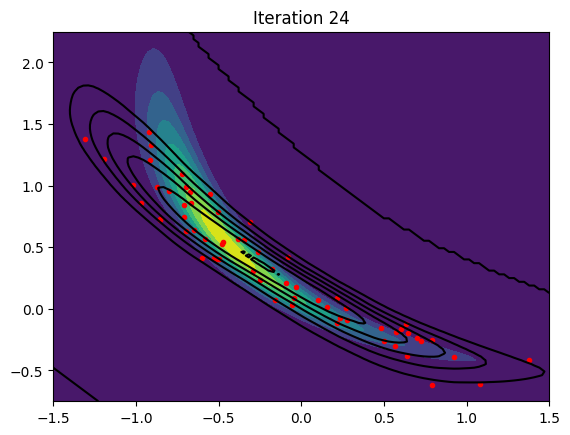

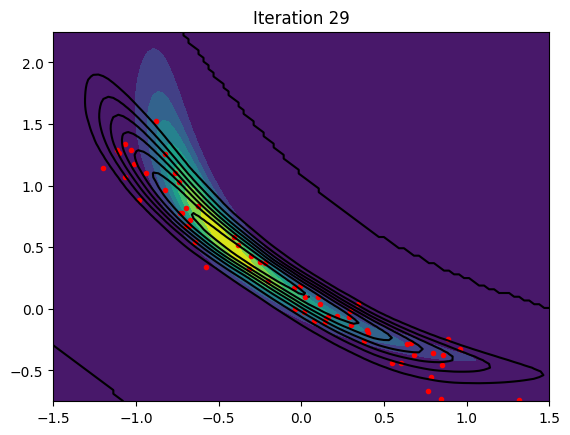

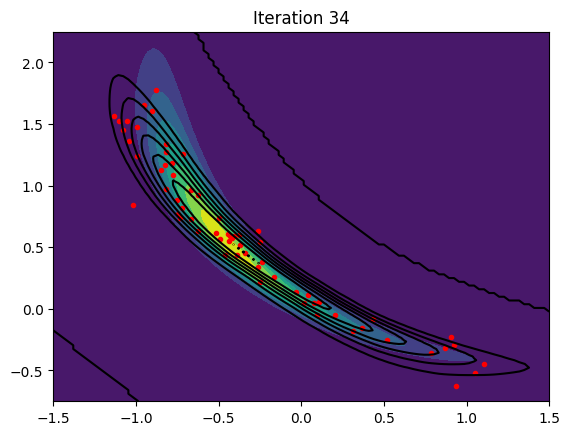

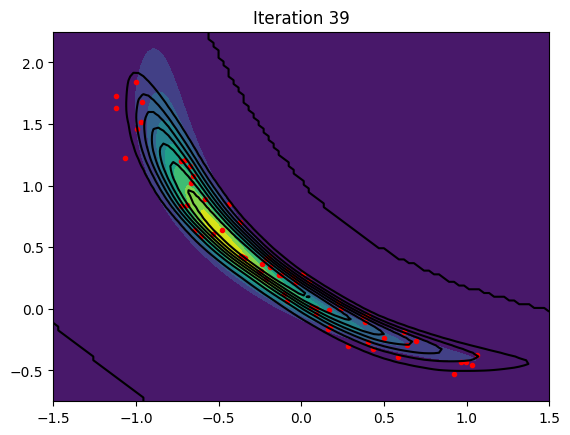

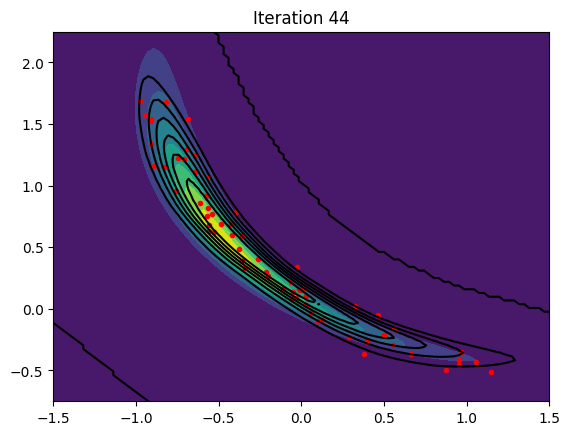

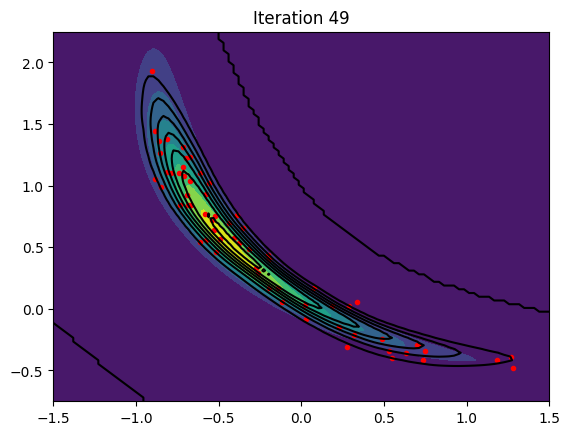

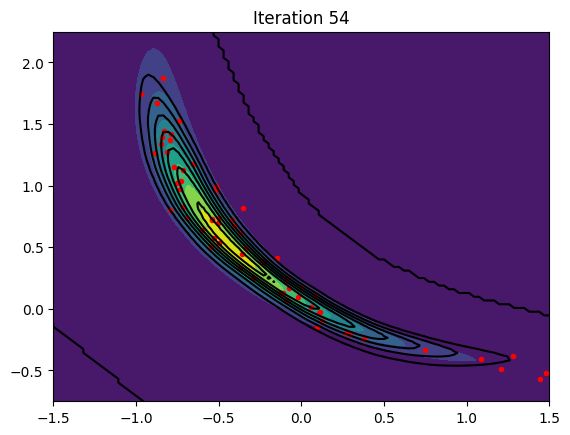

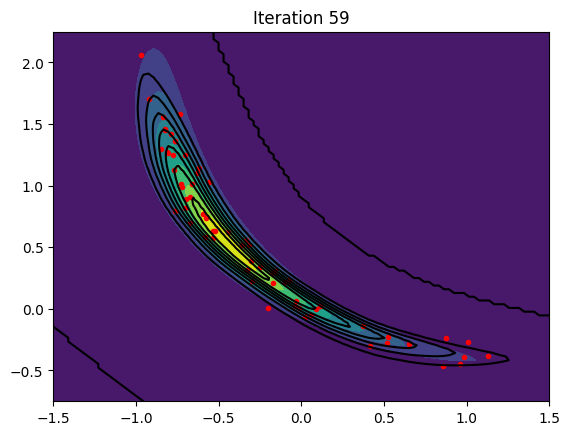

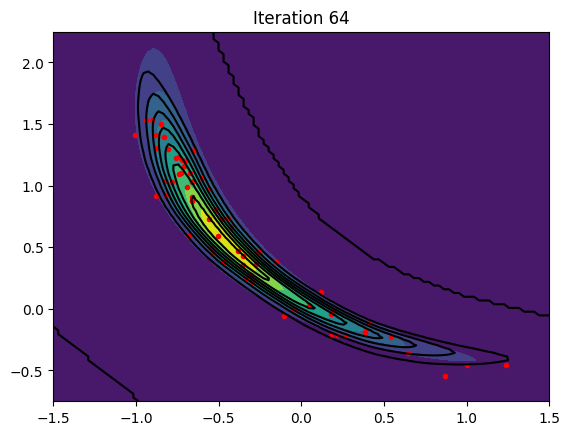

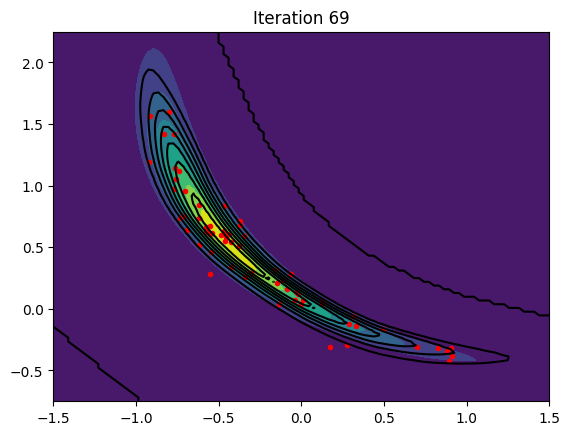

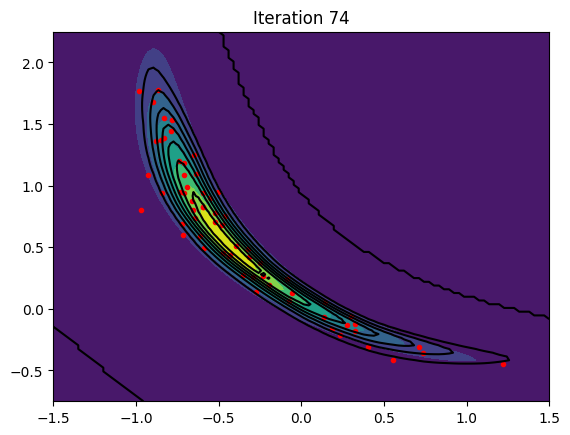

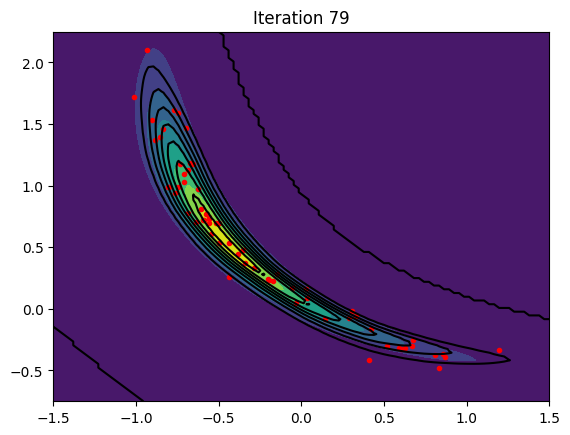

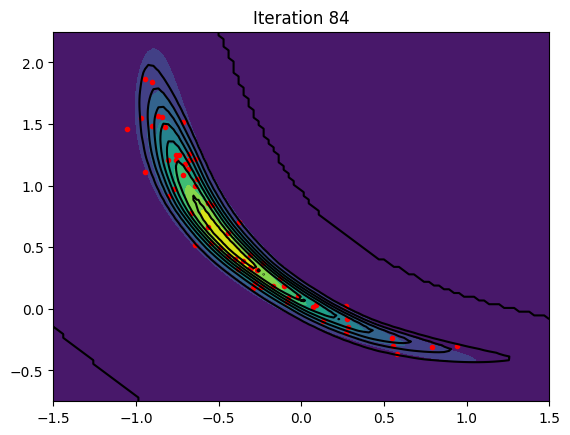

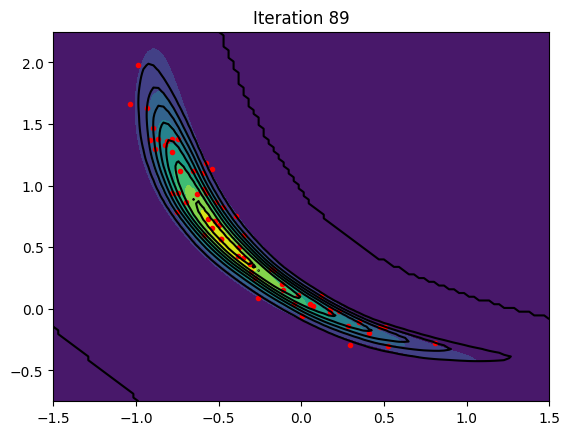

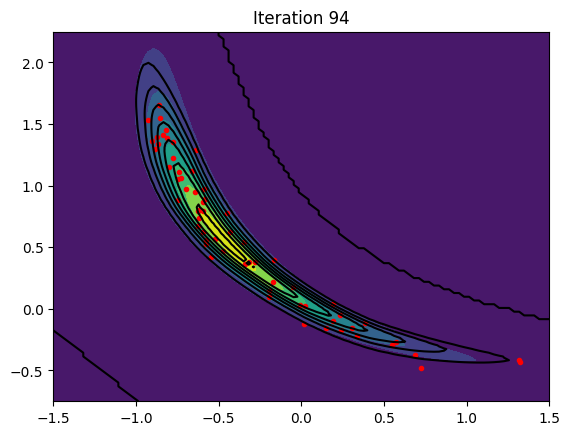

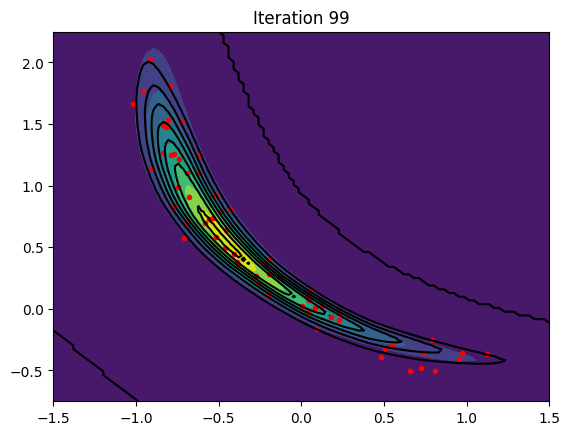

In [14]:
batch_size     = 64         # number of samples at each step
num_steps      = 100        # number of training steps
print_interval = 5          # interval for visualizing intermediate results

# define model
netb  = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Tanh())
neta  = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32))
pi    = posterior(y=y)
ref   = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow  = RealNVP(netb, neta, masks, pi, ref)

# define optimizer
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)

# define array for negative log-likelihood
his_nll = np.zeros((0,1))

print((2*"%6s   ") % ("step","J_NF"))

train_JML = 0.0
num_step = 0

for step in range(num_steps):

    # evaluate loss function
    x = flow.ref.sample((batch_size,))
    loss = -flow.log_prob(x).mean()
    
    # take gradient step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # store loss function
    train_JML += loss.item()
    num_step += 1

    # print loss and plot results
    if (step + 1) % print_interval == 0:
        train_JML /= num_step
        his_nll = np.vstack([his_nll, [train_JML]])
        train_JML = 0.0
        num_step = 0
        
        # evaluate and plot density
        log_px = flow.approximate_log_prob(xx).detach()
        xs = flow.sample(batch_size,).detach().numpy()
        plt.figure()
        plt.plot(xs[:,0],xs[:,1],'.r')
        plt.contourf(xg[0],xg[1],torch.exp(pi.log_prob(xx).detach().reshape(len(x1), len(x2))))
        plt.contour(xg[0],xg[1],torch.exp(log_px.reshape(len(x1), len(x2))), colors='black')
        plt.xlim(domain_x1)
        plt.ylim(domain_x2)
        plt.title(f'Iteration {step}')
        plt.show()


## Check the final result

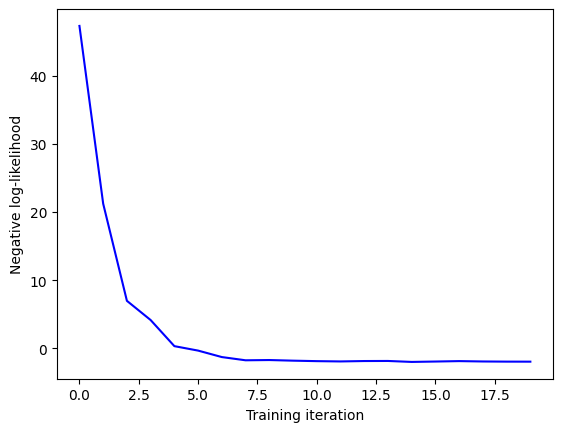

In [15]:
## Check convergence
plt.figure()
plt.plot(his_nll,'-b')
plt.xlabel('Training iteration')
plt.ylabel('Negative log-likelihood')
plt.show()

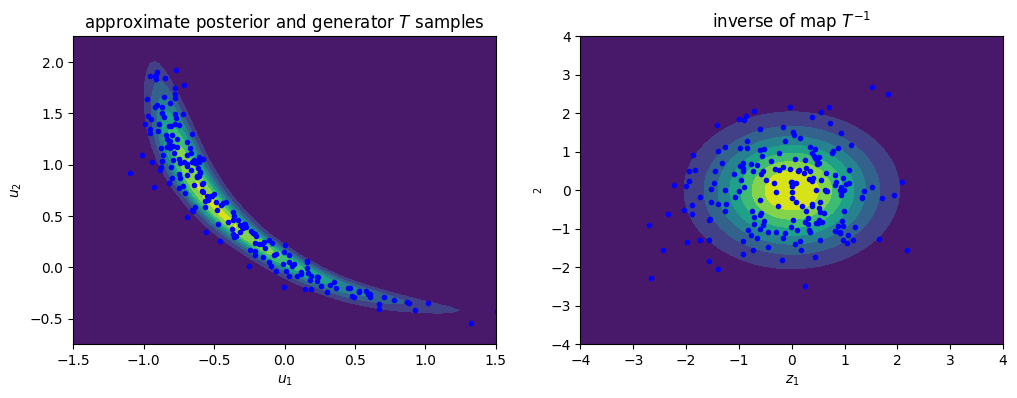

In [16]:
# generate test samples
Ntest = 200

# grid of the spatial domain (for plotting)
x1 = torch.linspace(domain_x1[0],domain_x1[1], 100)
x2 = torch.linspace(domain_x2[0],domain_x2[1], 100)
xg = torch.meshgrid(x1, x2)
xx = torch.cat((xg[0].reshape(-1, 1), xg[1].reshape(-1, 1)), 1)

# evaluate log-probability and sample model
log_px = flow.approximate_log_prob(xx).detach()
xs = flow.sample(Ntest).detach()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.contourf(xg[0],xg[1],torch.exp(log_px.reshape(len(x1), len(x2))))
plt.plot(xs[:,0],xs[:,1],'.b')
plt.title("approximate posterior and generator $T$ samples")
plt.xlabel("$u_1$")
plt.ylabel("$u_2$")
plt.xlim(domain_x1)
plt.ylim(domain_x2)

# grid of the spatial domain (for plotting reference)
domain_z1 = [-4,4]
domain_z2 = [-4,4]
z1 = torch.linspace(domain_z1[0],domain_z1[1], 100)
z2 = torch.linspace(domain_z2[0],domain_z2[1], 100)
zg = torch.meshgrid(z1, z2)
zz = torch.cat((zg[0].reshape(-1, 1), zg[1].reshape(-1, 1)), 1)

# evaluate density of latent distribution and sample latent space
log_pz = flow.ref.log_prob(zz).detach()
zs = flow.Tinv(xs)[0].detach().numpy()

plt.subplot(1,2,2)
plt.contourf(zg[0],zg[1],torch.exp(log_pz.reshape(len(x1), len(x2))))
plt.plot(zs[:,0],zs[:,1],'.b')
plt.title("inverse of map $T^{-1}$")
plt.xlabel("$z_1$")
plt.ylabel("$_2$")
plt.xlim(domain_z1)
plt.ylim(domain_z2)
plt.show()